In [1]:
# IMPORT PyEMMA
import pyemma
pyemma.__version__


# IMPORT GENERAL PACKAGES
import numpy as np
from IPython import get_ipython
get_ipython().run_line_magic('pylab','')
import pyemma.coordinates as coor
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Select appropriate Features
trajfile = 'JIP1_all_stripped_imaged.nc'
topfile = 'JIP1.prmtop'

feat = coor.featurizer(topfile)

feat.add_backbone_torsions(cossin=True)
feat.describe()[:10]

inp = coor.source(trajfile, feat)
print ('trajectory length = ',inp.trajectory_length(0))
print ('number of dimension = ',inp.dimension())

trajectory length =  200000
number of dimension =  36


In [3]:
# TIME-LAGGED INDEPENDENT COMPONENT ANALYSIS (TICA)
lag=100
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.95, kinetic_map=False)

Y = tica_obj.get_output()[0]
tica_output = tica_obj.get_output()

print ('Projected data shape = ',Y.shape)

Projected data shape =  (200000, 11)


In [4]:
tica_obj.cumvar

array([0.13551786, 0.26857186, 0.39062268, 0.50800228, 0.61304806,
       0.71136989, 0.78356365, 0.84150847, 0.89659264, 0.93548724,
       0.96059409, 0.97401925, 0.98152298, 0.9862787 , 0.98969978,
       0.99256776, 0.99454375, 0.99587711, 0.99695176, 0.99794611,
       0.99851794, 0.99893903, 0.99927883, 0.99955842, 0.99972989,
       0.99982858, 0.99989696, 0.99994213, 0.99996819, 0.999982  ,
       0.99998926, 0.99999602, 0.99999822, 0.99999969, 1.        ,
       1.        ])

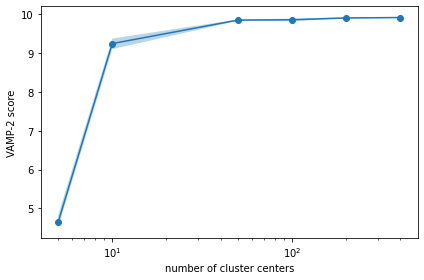

In [5]:
# find the number of cluster that necessary for our system by using Vamp 2 score
from pyemma.util.contexts import named_temporary_file
n_clustercenters = [5, 10, 50, 100, 200, 400]
scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()
fig.savefig('RMSD_JIP1__vamp_cluster_lag_100_dim10.pdf', bbox_inches='tight')

Retained dimension:  11


Text(0, 0.5, 'Cum. kinetic variance fraction')

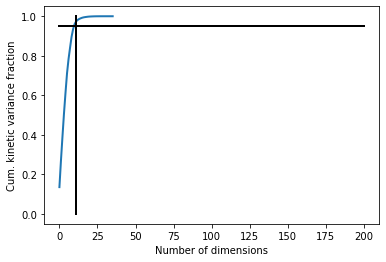

In [6]:
# number of dimention that we need to keep for the MSM
print ('Retained dimension: ', tica_obj.dimension())
plot(tica_obj.cumvar, linewidth=2)
plot([tica_obj.dimension(), tica_obj.dimension()], [0, 1], color='black', linewidth=2)
plot([0, 200], [0.95, 0.95], color='black', linewidth=2)
xlabel('Number of dimensions'); ylabel('Cum. kinetic variance fraction')

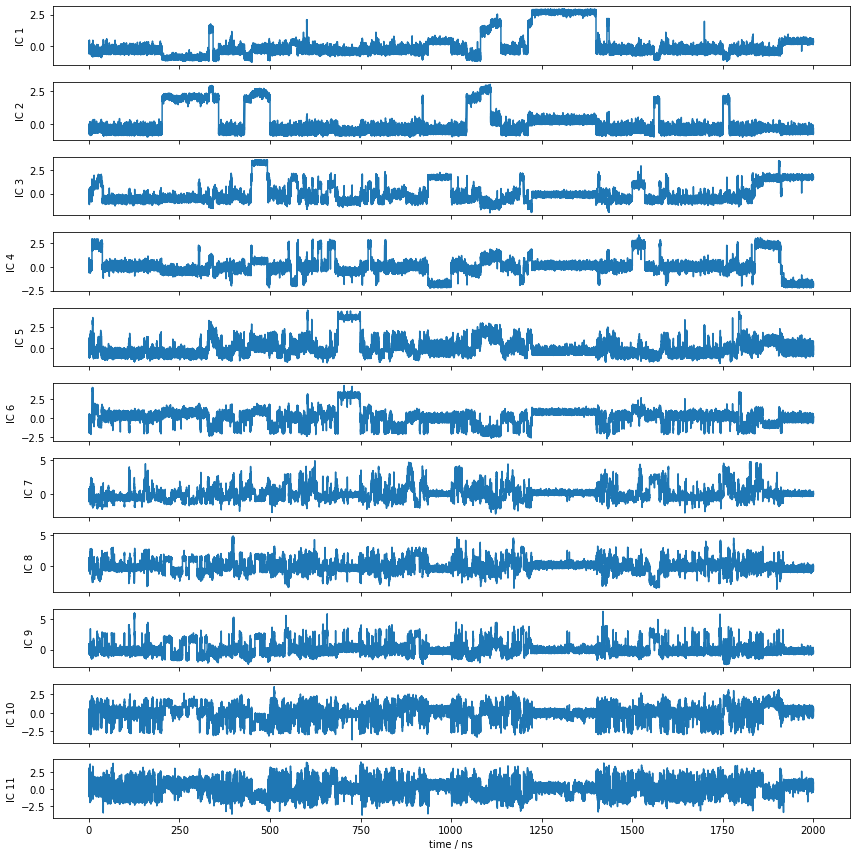

In [7]:
# First 11 TICA 
fig, axes = plt.subplots(11, 1, figsize=(12, 12), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x/10, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
fig.savefig('RMSD_JIP1__TICAs_lag_100_dim10.pdf', bbox_inches='tight')
fig.savefig('RMSD_JIP1__TICAs_lag_100_dim10.png', bbox_inches='tight')

In [8]:
#We use k-means clustering and get the discrete trajectories
cl = coor.cluster_kmeans(data=Y, k=250, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

100%|██████████| 250/250 [00:06<00:00, 39.94it/s]                             

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


[3073.42525702 2397.4359998  1178.27317971  958.01817599  625.42764245]


C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


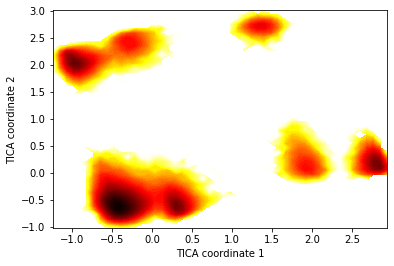

<Figure size 432x288 with 0 Axes>

In [9]:
# Free energy lanscape
print (-lag/np.log(tica_obj.eigenvalues[:5]))

# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');

plt.show()
plt.savefig('RMSD_JIP1_energy_surface_backbone_time_lag_100_dim10.png', bbox_inches='tight')

100%|██████████| 250/250 [00:06<00:00, 39.94it/s]                             

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[array([40, 40, 40, ..., 48, 97,  0])]

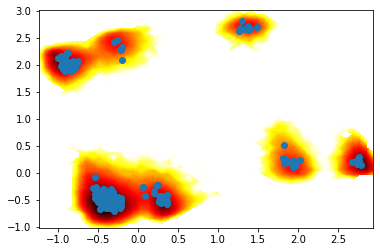

In [10]:
import matplotlib.pyplot as plt
cl = coor.cluster_kmeans(data=Y, k=250, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.plot(cc_x,cc_y, linewidth=0, marker='o')

cl.dtrajs

In [11]:
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]                                 


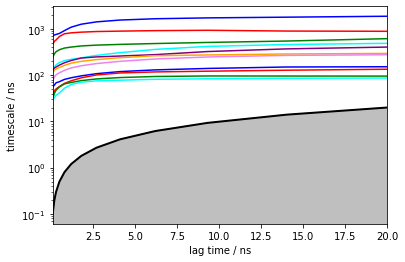

In [12]:
# implied timescale as a function of lagtime
import pyemma.msm as msm
import pyemma.plots as mplt

its = msm.its(dtrajs, lags=200, nits=11)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
#mplt.plot_implied_timescales(its)

100%|██████████| 13/13 [00:25<00:00,  1.95s/it]                        


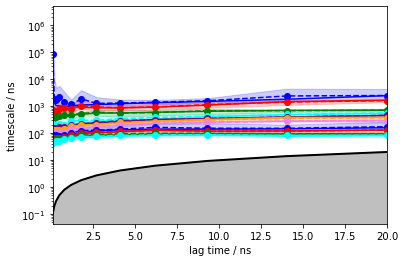

In [13]:
# implied timescale as a function of lagtime with Baysian sampling

its = pyemma.msm.its(dtrajs, lags=200, nits=11, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
plt.savefig('RMSD_JIP1_lag_100_dim11.pdf', bbox_inches='tight')

100%|██████████| 100/100 [00:01<00:00, 64.73it/s]                                                                   


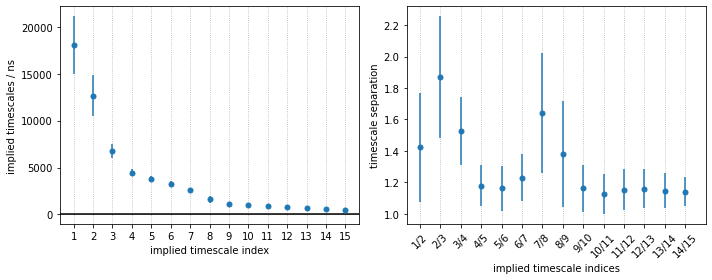

In [14]:
# timescale seperation for defiding the total number of metastable states in the system

M = msm.bayesian_markov_model(dtrajs, 100)


def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = M.sample_mean('timescales', k=nits)
timescales_std = M.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(M.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, M.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
plt.show()
fig.savefig('BPTI_JIP1_MSM_Ratio_spectral_time_lag_100_cutoff95_k250.pdf', bbox_inches='tight')

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]                        


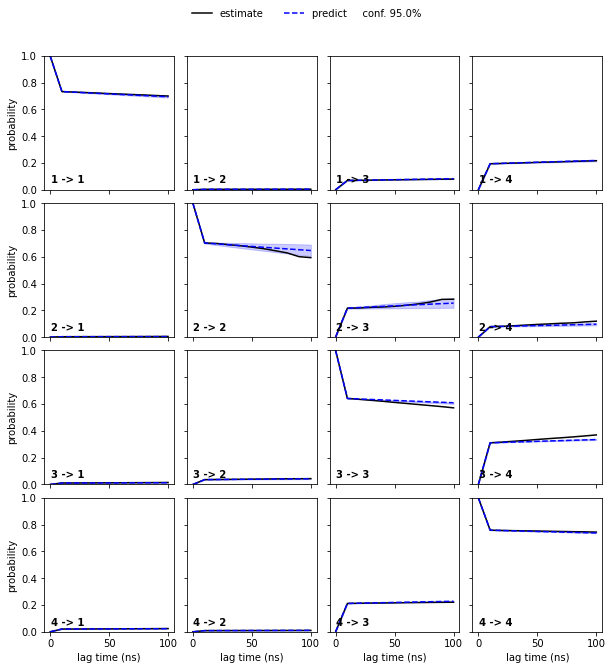

<Figure size 432x288 with 0 Axes>

In [15]:
nstates = 4
cktest = M.cktest(nstates, mlags=11,  err_est=False)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
plt.show()
plt.savefig('cktest_lag_100_k250.pdf', bbox_inches='tight')

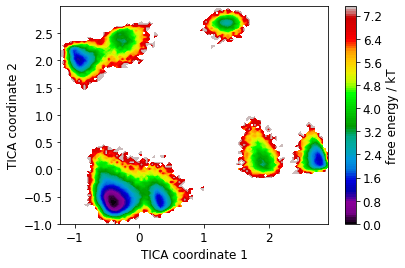

In [16]:
#Free energy landscape as a function of first two TICA
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())
# TODO: make this an MSM-weighted free energy plot
matplotlib.rcParams.update({'font.size': 12})
mplt.plot_free_energy(xall, yall)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');

plt.savefig('conformer_energy_weight_lag_100_k250.png', bbox_inches='tight')